# Hello, Julia!
> What I learnt and implemented 

- toc: true
- layout: post
- categories: [machine learning, maths]
- comments: true
- image: images/julia.jpg

Hey! This post is about my introduction to the world of Julia. I took this challenge of learning Julia and making something in it. Since Julia is pretty similar to Python, I made a hypothesis. That is can I learn julia and be up and running with something in two days? What I realised is, if you're from a python background and have some expereince in it, then learning Julia is going to be fun and breezy for you. So, here I am after my two day rendezvous with Julia.

So, what I used to learn Julia?
I used resources from [julia academy](https://juliaacademy.com/)

What did I implement?
I decided to go for one the resources I learnt deep learning from: [Neural Networks and Deep Learning](https://www.coursera.org/learn/neural-networks-deep-learning/home/welcome)

- Impemented the Julia version of [Week 2 assignment](https://www.coursera.org/learn/neural-networks-deep-learning/notebook/zAgPl/logistic-regression-with-a-neural-network-mindset) of [Neural Networks and Deep Learning](https://www.coursera.org/learn/neural-networks-deep-learning/home/welcome) course.

- It's not exactly that actually, I have applied the concepts to banknote authentication.
- Data is from UCI machine learning repository
- Training is done, inference is on the way!

I hope it's useful to you. It was a lot of fun and I am in love with Julia ❤

Let's begin!

In [1]:
# export

using DelimitedFiles
using Random
using Plots

In [2]:
file = DelimitedFiles.readdlm(raw"C:\Users\Abhishek Swain\Desktop\Julia_ML\deeplearning.ai\Neural Networks and deep learning\Week-2\data_banknote_authentication.txt", ',');


See the first 5 rows of the given array

In [3]:
function head(file)
    file[1:5, 1:5]
end

head (generic function with 1 method)

In [4]:
head(file)

5×5 Array{Float64,2}:
 3.6216    8.6661  -2.8073  -0.44699  0.0
 4.5459    8.1674  -2.4586  -1.4621   0.0
 3.866    -2.6383   1.9242   0.10645  0.0
 3.4566    9.5228  -4.0112  -3.5944   0.0
 0.32924  -4.4552   4.5718  -0.9888   0.0

## Normalization

In [5]:
function normalize(file, num_cols)
    for i=1:num_cols
        file[:, i] /= sum(file[:, i])
    end
end

normalize (generic function with 1 method)

In [6]:
normalize(file, 4)

In [7]:
head(file)

5×5 Array{Float64,2}:
 0.00608586    0.00328576  -0.00146401   0.000273396  0.0
 0.00763908    0.00309668  -0.00128216   0.000894277  0.0
 0.00649655   -0.00100032   0.00100347  -6.51089e-5   0.0
 0.00580858    0.00361058  -0.00209184   0.00219847   0.0
 0.000553266  -0.0016892    0.0023842    0.000604788  0.0

## Splitting into train & test set
splits the data into train and test set

In [8]:
function train_test_split(file, at=0.7)
    n = size(file, 1)

    idx = shuffle(1:n)
    
    train_idx = view(idx, 1:floor(Int, at*n))
    test_idx = view(idx, (floor(Int, at*n)+1):n)
    
    file = convert(Matrix, file)
    return file[train_idx,:], file[test_idx,:]

end

train_test_split (generic function with 2 methods)

In [9]:
data_train, data_test = train_test_split(file);

X_train, y_train = data_train[:, 1:4], data_train[:, 5];

## **Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

## Sigmoid
Applies sigmoid to the vector

In [10]:
function σ(z) 
    """
    Compute the sigmoid of z
    """
    return one(z) / (one(z) + exp(-z))
end

σ (generic function with 1 method)

## Random initialization
Initialize `w` & `b` with with random values between (0, 1)

In [11]:
function initialize(dim)
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = zeros(dim, 1)
    b = 2
    
    @assert(size(w) == (dim, 1))
    @assert(isa(b, Float64) || isa(b, Int64))
    
    return w, b
end

initialize (generic function with 1 method)

## Notation

- According to our notation, `X` is of shape *(num_features, num_examples)*, in our case that is (4, 343). So, we need to reshape our `X`.
- `m` is the number of tranining examples.
- Similarly, `y` is a row vector or as Julia likes to call it `Array{Float64, 2}` of shape *(1, num_examples)*. 

In [12]:
X_train = reshape(X_train, (size(X_train, 2), size(X_train, 1)))
size(X_train)

(4, 960)

In [13]:
m = size(X_train, 2)

960

In [14]:
y_train = reshape(y_train, (1, size(y_train, 1)))

1×960 Array{Float64,2}:
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  …  1.0  1.0  0.0  1.0  1.0  1.0  1.0

In [15]:
cost = Array{Float64, 2}(undef, size(X_train, 2), 1);

## Forward and Backward propagation

`propagate` function is the function at the heart of the algorithm. This does the **forward prop -> calculate cost -> back-prop**.

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$


In [16]:
function propagate(w, b, X, Y)
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation
    """
    
    # Forward prop
    Z = w'X .+ b
    A = σ.(Z)
    @assert(size(A) == size(y_train))
    
    # Compute cost
    𝒥 = -1 * sum(y_train .* log.(A) .+ (1 .- y_train) .* log.(1 .- A))
    𝒥 /= m
    
    # Back-prop
    dz = A - Y
    @assert(size(dz) == size(A) && size(dz) == size(Y))
        
    dw = (1/m) * X * dz'
    db = (1/m) * sum(dz)
    
    𝒥, dw, db
end

propagate (generic function with 1 method)

In [17]:
w, b = initialize(size(X_train, 1))

([0.0; 0.0; 0.0; 0.0], 2)

## Model
Combine all functions to train the model
<br>
Learning rate: $\alpha = 0.09$, iterations(epochs): 150

Here is something I love about Julia. It's that you can directly use symbols as variables 😍. Doesn't it look awesome? 

In [18]:
α = 0.01

cost = Array{Float64, 2}(undef, 1500, 1)

for i=1:1500
    
    𝒥, dw, db = propagate(w, b, X_train, y_train)
    
    cost[i] = 𝒥
    
    global w, b
    
    w -= α * dw;  
    b -= α * db;
        
    if i % 100 == 0 
        println("cost after iteration $i: $𝒥")
    end

end  

cost after iteration 100: 1.0666073239687341
cost after iteration 200: 0.9391282495029152
cost after iteration 300: 0.8489316681990057
cost after iteration 400: 0.7885819340786782
cost after iteration 500: 0.7498169972649182
cost after iteration 600: 0.7255735812223848
cost after iteration 700: 0.7106522022601075
cost after iteration 800: 0.7015484569536741
cost after iteration 900: 0.6960180608207343
cost after iteration 1000: 0.6926643346133461
cost after iteration 1100: 0.690631350001049
cost after iteration 1200: 0.689398600784405
cost after iteration 1300: 0.6886506399682504
cost after iteration 1400: 0.6881965056746137
cost after iteration 1500: 0.6879205859540563


## Plotting 
For plotting we use the `Plots` package.

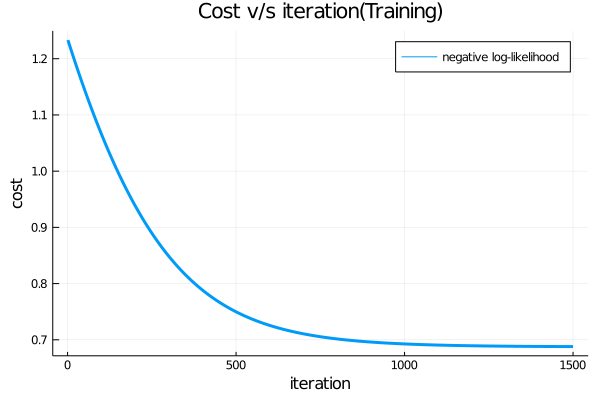

In [19]:
x = 1:1500;
y = cost;

gr() # backend

plot(x, y, title = "Cost v/s iteration(Training)", label="negative log-likelihood", lw=3)
xlabel!("iteration")
ylabel!("cost")

In [20]:
function predict(w, b, X)
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """
    
    m = size(X, 1)
    Y_pred = zeros(1, m)
    X = reshape(X, (size(X, 2), size(X, 1)))
    
    A = σ.(w'X .+ b)
    
    for i=1:size(A, 2)
        
        if(A[i] > 0.5)
            Y_pred[i] = 1
        else
            Y_pred[i] = 0
        end
    end
    
    @assert(size(Y_pred) == (1, m))
        
    Y_pred
    
end

predict (generic function with 1 method)

In [21]:
X_test, y_test = data_test[:, 1:4], data_test[:, 5];

In [22]:
preds = predict(w, b, X_test)

1×412 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [23]:
y_test = reshape(y_test, (1, 412))

1×412 Array{Float64,2}:
 1.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  …  1.0  0.0  1.0  0.0  0.0  0.0  0.0

In [24]:
cnt = 0

for i=1:size(y_test, 2)
    
    if(y_test[i] == preds[i])
        cnt +=  1
    end
end

In [25]:
acc = (cnt/size(y_test, 2)) * 100;

In [26]:
println("Accuracy: $acc")

Accuracy: 56.067961165048544


## Epilouge

You can see accuracy is really just 56% which is what to say 🤣🤣, but then I have not done any preprocessing except normalization & then there are also things we can do to optimize, like handling class-imbalance etc.

The goal was to implement Logistic regression with back-prop from scratch which I did. Hope you will take something from it.

## Github repo for notebook: [Julia_ML](https://github.com/Abhiswain97/Julia_ML)

As always, thank you for reading 😊😃!